# TIME SERIES CLASSIFICATION
 

In [2]:
# Importing libraries declaration 

import glob 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler


warnings.filterwarnings('ignore')  # Used to avoid any warnings in the output 

# This is a function to splits the dataset into l parts and dyamically concatinates the splitted half into columns. 
def split(df, p):
    rows = df.shape[0]               # finds the size of rows 
    length = rows - (rows%p)         # To divide the dataset into uniform splits 
    size = rows//p                   # Finding the size of splits 
    final_df = pd.DataFrame()
    for i in range(0,length,size):
        df_list = df.loc[i:i+size-1,:]  # Splits based on the size. 
        df_list.index = range(size)      # Reindexing it to no of instances. i.e. 88 
        final_df = pd.concat([final_df, df_list], axis = 1)   # Concatinates dataframes with axis 1 i.e. to columns 
    return final_df

# function to extract features from time series and present into a representable dataframe format
def dataset(l):

    folder = ['bending2', 'cycling', 'lying','sitting', 'standing', 'walking']
    file = sorted(glob.glob('AReM/bending1/*.csv'))

    for i in folder:
        path = 'AReM'                                                # this loop extracts the dataset from different folders and converts into a list
        file1 = sorted(glob.glob(path + '//' + i + '/dataset*.csv'))     
        file.extend(file1)

    
    cols=[]           # This loop dynamically creates of list and appends the column name i.e. the features followed by the timeseries of particular attribute. 
    list_cols =['mean','std','min','1st quart','median','3st quart','max']
    for p in range(1,(6*l)+1):
        for q in range(0,7):
            cols.append(list_cols[q]+str(p))
    # this part is to read the csv's present in a list and make a dataframe. The split function is called which splits 
    # based on the number mentioned in the argument. It varies from 1 to 20. 
    total = []
    df_temp_full = pd.DataFrame()
    df_test = df_temp_full
    df_train = df_temp_full
    for p in range(len(file)):
        data = pd.read_csv(file[p], skiprows=4, error_bad_lines=False, usecols = ['avg_rss12', 'var_rss12','avg_rss13','var_rss13','avg_rss23', 'var_rss23'])
        df = pd.DataFrame(data)
        df = split(df, l)
        df = df.describe()  # Extracts the essential features from the time series. 
        df = df.drop(['count'])
        total.append(df.T)
        if p == 0 or p == 1 or p == 7 or p == 8 or p == 13 or p == 14 or p == 15 or p == 28 or p == 29 or p == 30 or p == 43 or p == 44 or p == 45 or p == 58 or p == 59 or p == 60 or p == 72 or p == 73 or p == 74:
        
            df_temp_test = total[p]
            df_temp_test.index = range(len(df.columns)) 
            df_temp_test= split(df_temp_test, len(df.columns))   # Creates a different test dataframe based on the splits mentioned in part 1b
            df_test = pd.concat([df_test, df_temp_test])
        else:
            df_temp_train = total[p]
            df_temp_train.index = range(len(df.columns)) 
            df_temp_train= split(df_temp_train, len(df.columns))  # Cretes a different train dataframe based on the split mentioned in part 1b
            df_train = pd.concat([df_train, df_temp_train])
        
    df_train.index = range(69)
    df_test.index = range(19)
    df_train.columns = cols
    df_test.columns = cols
        
    df_train.loc[:,'class'] = pd.Series([0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
    df_test.loc[:,'class'] = pd.Series([0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
    target = 'class'
    X_train = df_train.loc[:, df_train.columns != target]   # Training dataset
    y_train = df_train.loc[:, df_train.columns == target]
    X_test = df_test.loc[:, df_test.columns != target]     # Test dataset
    y_test = df_test.loc[:, df_test.columns == target]
    return X_train, y_train, X_test, y_test, df_train

In [2]:
X_train, y_train, X_test, y_test, df_train = dataset(1)

In [3]:
X_train.head()

,mean1,std1,min1,1st quart1,median1,3st quart1,max1,mean2,std2,min2,...,median5,3st quart5,max5,mean6,std6,min6,1st quart6,median6,3st quart6,max6
0,43.954500,1.558835,35.00,43.00,44.33,45.00,47.40,0.426250,0.338690,0.0,...,36.00,36.50,38.50,0.493292,0.513506,0.0,0.00,0.43,0.94,1.79
1,42.179813,3.670666,33.00,39.15,43.50,45.00,47.75,0.696042,0.630860,0.0,...,35.00,36.33,38.67,0.613521,0.524317,0.0,0.00,0.50,1.00,2.18
2,41.678063,2.243490,33.00,41.33,41.75,42.75,45.75,0.535979,0.405469,0.0,...,30.00,31.25,37.50,0.383292,0.389164,0.0,0.00,0.43,0.50,1.79
3,43.454958,1.386098,37.00,42.50,43.25,45.00,48.00,0.378083,0.315566,0.0,...,23.50,24.00,33.50,0.679646,0.622534,0.0,0.43,0.50,0.87,5.26
4,43.969125,1.618364,36.25,43.31,44.50,44.67,48.00,0.413125,0.263111,0.0,...,21.67,23.75,30.75,0.555313,0.487826,0.0,0.00,0.49,0.83,2.96


### Part 1d(i)

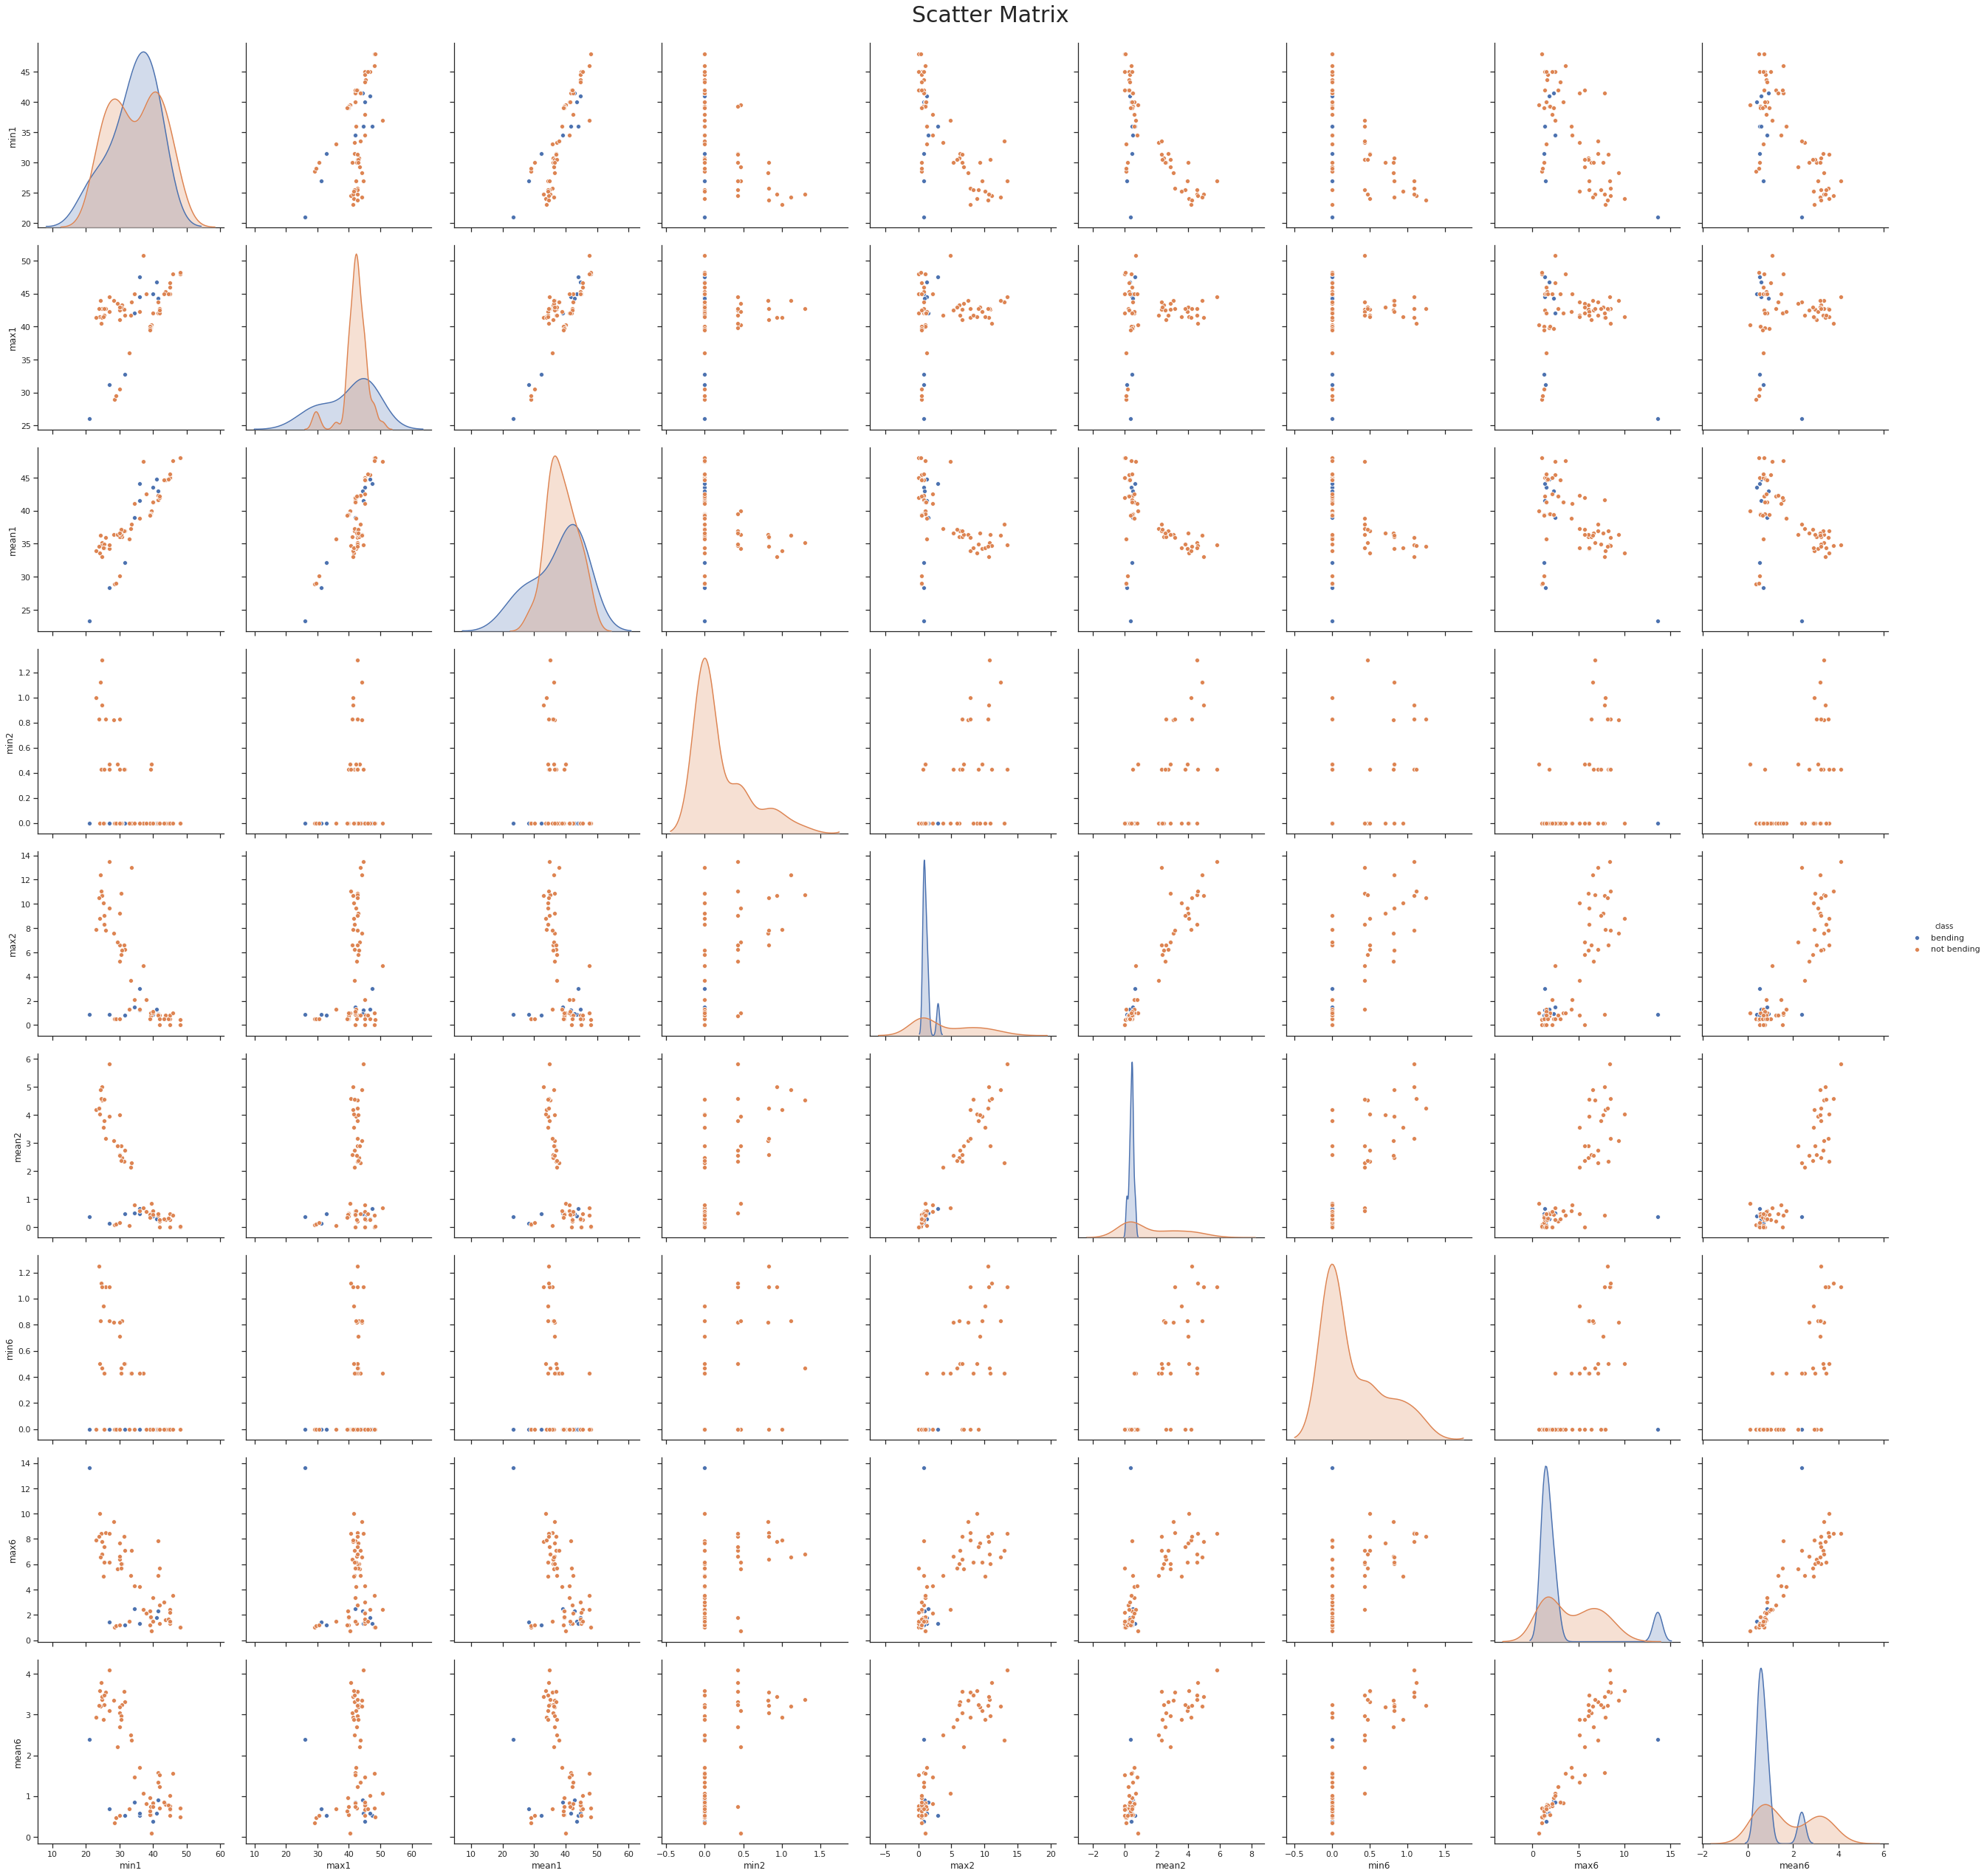

In [10]:
df_train_new = df_train[['min1','max1','mean1','min2','max2','mean2','min6','max6','mean6']]  #Extracting essential feaatures
df_train_new.loc[:,'class'] = pd.Series([0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
df_train_new['class'] = ['bending' if x == 0 else 'not bending' for x in df_train_new['class']]

#Plotting the scatterplot
sns.set(style = 'ticks')
sns.pairplot(df_train_new, hue = 'class', height = 4)
plt.suptitle("Scatter Matrix", fontsize = 30)
plt.subplots_adjust(top = 0.96)
#plt.show()

### Part 1d(ii)

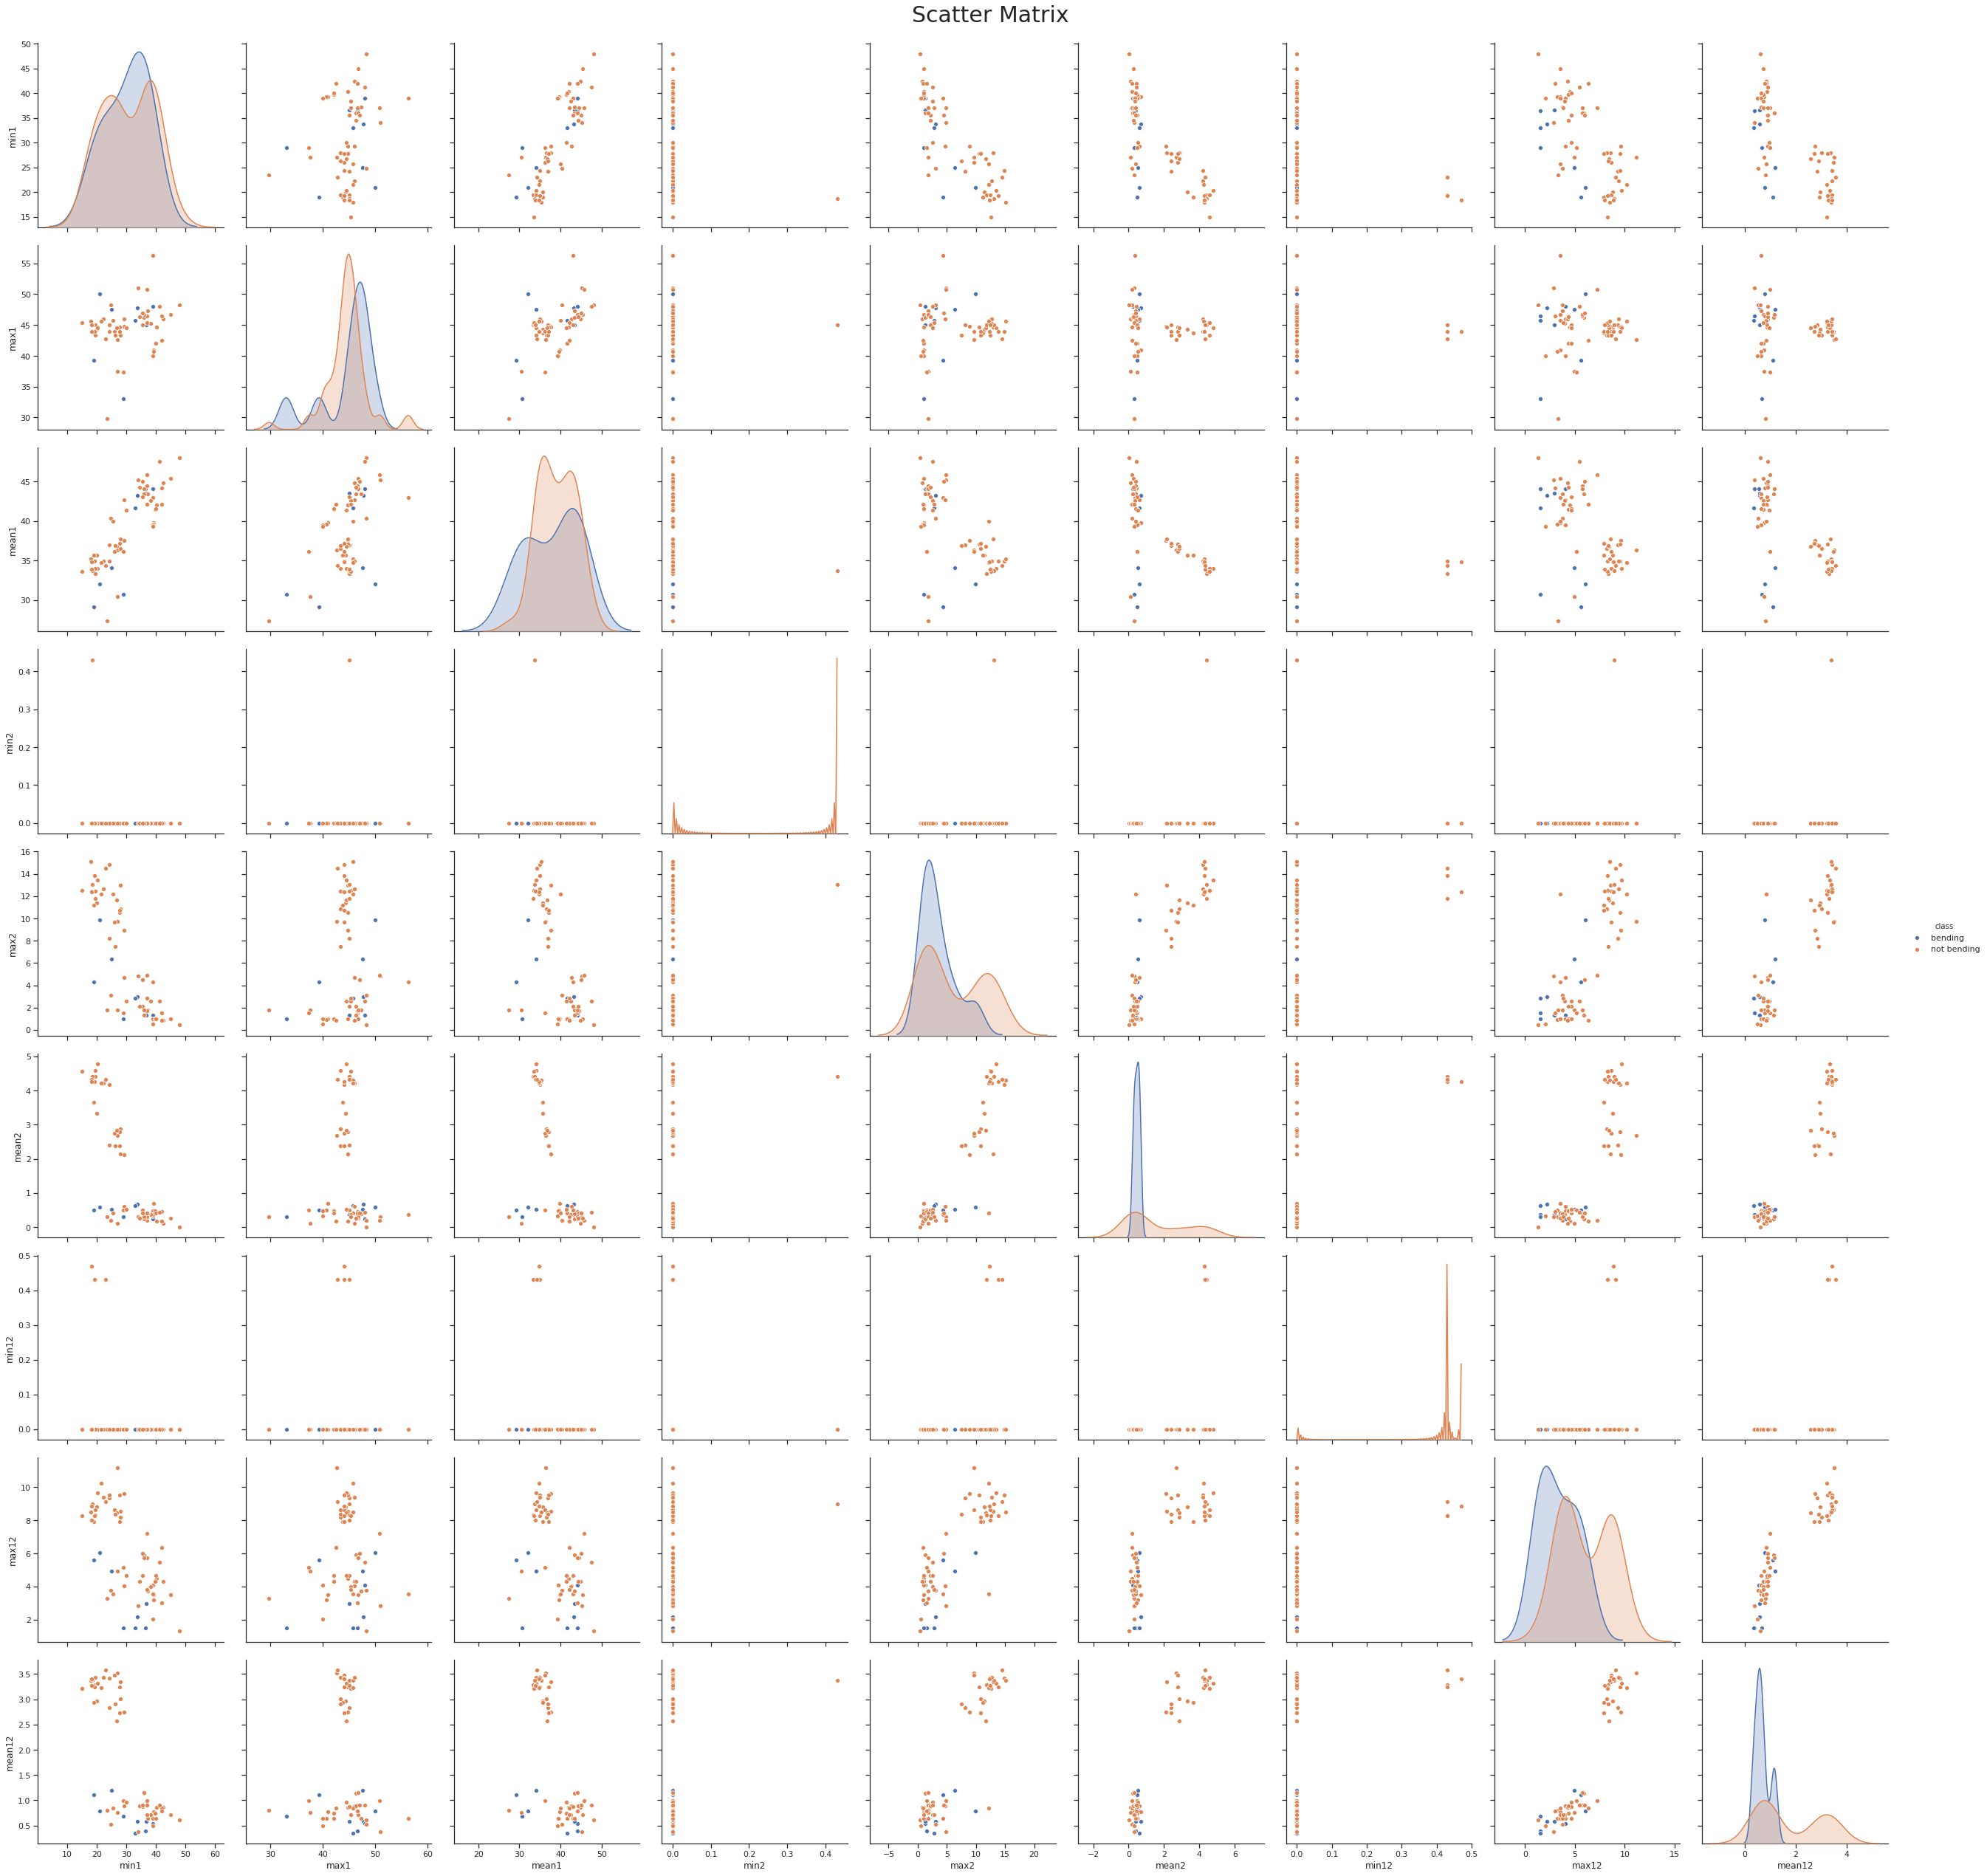

In [5]:
X_train, y_train, X_test, y_test, df_train = dataset(2)  #calling the function declared above

df_train_new = df_train[['min1','max1','mean1','min2','max2','mean2','min12','max12','mean12']] #Extracting essential features
df_train_new.loc[:,'class'] = pd.Series([0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
df_train_new['class'] = ['bending' if x == 0 else 'not bending' for x in df_train_new['class']]  # Finding this to plot the scatterplot

# Plotting the scatterplot
sns.set(style = 'ticks')
sns.pairplot(df_train_new, hue = 'class', height = 4)
plt.suptitle("Scatter Matrix", fontsize = 30)
plt.subplots_adjust(top = 0.96)

### Part 1d(iii)

### We see that as the l increases from 1 to 20, the number of features increases. When the number of features increases beyond the number of samples, it gets difficult to estimate the prediction. So, we go for feature elimination. In the program, it is done by a model called Reduced Feature Eimination with Cross Validation. The model uses the estiamator as Logistic Regression and validates on 5 folds. The RFECV model extracts essential features from the set of features and cross validates on the validation set bringing a good train accuracy. The training data fits the model perfectly. 

In [5]:
l = list(x for x in range(0, 20))  # Making a list l. 
plist, score = ([] for i in range(2))

for i in range(1, len(l)+1):  #Loop for calculating the best l & p for dataset by using reduced feature eliminition
    X_train, y_train, X_test, y_test, df_train = dataset(i)  #calling the function dataset
    model = LogisticRegression()  #Instantiating the model as Logistic Regression
    rfecv = RFECV(estimator = model, cv=StratifiedKFold(5), scoring = 'accuracy')
    rfecv.fit(X_train, y_train)  #Fitting the RFECV model. It uses RFE and Cross validation both. 
    print("Optimal number of features for l=",i,": %d" % rfecv.n_features_)
    print("Max cross validation score:", np.max(rfecv.grid_scores_))
    plist.append(rfecv.n_features_)  #Appending the eliminated features to a list
    score.append(np.max(rfecv.grid_scores_))    # Appending the max CV score found in each iteration
    

Optimal number of features for l= 1 : 4
Max cross validation score: 0.9857142857142858
Optimal number of features for l= 2 : 4
Max cross validation score: 0.9857142857142858
Optimal number of features for l= 3 : 8
Max cross validation score: 1.0
Optimal number of features for l= 4 : 6
Max cross validation score: 0.9857142857142858
Optimal number of features for l= 5 : 13
Max cross validation score: 0.9857142857142858
Optimal number of features for l= 6 : 18
Max cross validation score: 0.9857142857142858
Optimal number of features for l= 7 : 32
Max cross validation score: 0.9857142857142858
Optimal number of features for l= 8 : 23
Max cross validation score: 0.9714285714285715
Optimal number of features for l= 9 : 5
Max cross validation score: 0.9714285714285715
Optimal number of features for l= 10 : 71
Max cross validation score: 0.9714285714285715
Optimal number of features for l= 11 : 9
Max cross validation score: 0.9714285714285715
Optimal number of features for l= 12 : 6
Max cross 

### The next cell gives the best l & p pair. It is decided based on the best validation score given by the model by extracting a p for a particular l. 

In [7]:
df_bestp = pd.DataFrame({'p features':plist, 'CV score':score})
df_bestp.index = np.arange(1, 21)
df_bestp = df_bestp.sort_values(by= ['CV score'], ascending=False)
print("The best l and p value is")
df_bestp.iloc[0]

The best l and p value is


p features    8.0
CV score      1.0
Name: 3, dtype: float64

### Part 1d(iv)

### The next cell uses the l got from the best l&p pair and uses RFE model for calculating the confusion matrix. The confusion matrix gives an idea of the datapoints which are classified or misclassified. We see that no point is misclassified, rather every point is classified as either bending or not bending. 

In [8]:
X_train, y_train, X_test, y_test, df_train = dataset(3)  # calling the function dataset
model_train = LogisticRegression(solver='liblinear')  # Instantiating the model logistic regression
rfe = RFE(model_train, 8)
rfe.fit(X_train, y_train)  # Fitting the model on training data
y_pred = rfe.predict(X_train) # Uses the training data to predict the model. 

confusion_matrix = confusion_matrix(y_train, y_pred)
print("CONFUSION MATRIX")
print(confusion_matrix)
cols = list(X_train.columns[rfe.support_])


CONFUSION MATRIX
[[ 9  0]
 [ 0 60]]


### The next cell gives the ROC curve. This curve gives information about how the classification and misclassification varies if we change the threshold. 
### The ROC we got is an ideal ROC with AOC as 100%. 

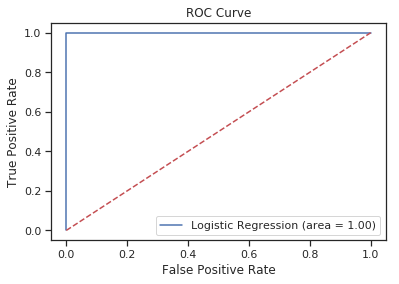

In [9]:
X_train, y_train, X_test, y_test, df_train = dataset(3)
rfe_score = roc_auc_score(y_train, y_pred)
fpr, tpr, thresholds= roc_curve(y_train, rfe.predict_proba(X_train)[:,1])  # calculates the false positive rate, true positive rate
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % rfe_score)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### The below cell prints out the coef of the features extracted in the above cells. It prints out the p-value which is near to 1. It implies that we can reject the null hypothesis. It is due to well seperated classes. 

In [10]:
import statsmodels.api as sm

df_train_new_trial = df_train[cols]
logit_model1=sm.Logit(y_train, df_train_new_trial)
model1 = logit_model1.fit(method = 'lbfgs')
print(model1.summary())

                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                   69
Model:                          Logit   Df Residuals:                       61
Method:                           MLE   Df Model:                            7
Date:                Wed, 26 Jun 2019   Pseudo R-squ.:                   1.000
Time:                        22:55:00   Log-Likelihood:            -4.1917e-05
converged:                       True   LL-Null:                       -26.718
                                        LLR p-value:                 3.041e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
max2           0.6768    318.340      0.002      0.998    -623.259     624.612
mean5         -1.0173   2031.012     -0.001      1.000   -3981.727    3979.693
min5          -1.4566    133.243     -0.011      0.9

### Part  1d(v)

In [11]:
X_train, y_train, X_test, y_test, df_train = dataset(3)
model_test = LogisticRegression(solver='liblinear')
rfe = RFE(model_test, 8)
rfe.fit(X_test, y_test.values.ravel())
y_pred_test = rfe.predict(X_test)
print("Max cross validation score:", rfe.score(X_test, y_test))

Max cross validation score: 1.0


### Part 1d(vi)

### Yes, the classes are well seperated and we got the p-values to be near to 1. Which implies that the model will not function properly.  

### Part 1d(vii)

### Used SMOTE to upsample and make the imbalance class balanced. The training data showed drastic imbalance. Used GridSearchCV to calculate the parameters and adjusted it in the logistic regression. 

In [3]:
X_train, y_train, X_test, y_test, df_train = dataset(3)

smote = SMOTE(random_state=2)
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

parameters = {'C': np.linspace(1, 10, 10)}

mod_lr = LogisticRegression()
gs= GridSearchCV(mod_lr, parameters, cv=5)
gs.fit(X_train_sm, y_train_sm)


mod_lr_1 = LogisticRegression(C = gs.best_params_.get('C'))
mod_lr_1.fit(X_train_sm, y_train_sm)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [4]:
y_train_pre = mod_lr_1.predict(X_train)

confusion_matrix_1 = confusion_matrix(y_train, y_train_pre)
print("CONFUSION MATRIX")
print(confusion_matrix_1)

CONFUSION MATRIX
[[ 9  0]
 [ 0 60]]


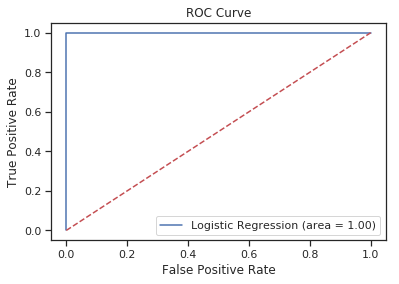

In [29]:
rfe_score = roc_auc_score(y_train, y_train_pre)
fpr, tpr, thresholds= roc_curve(y_train, mod_lr_1.predict_proba(X_train)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % rfe_score)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Part e(i)

### The following cell uses l1 penalization for feature selection. 

In [8]:
l = list(x for x in range(1, 22))
plist = []
score = []
   
    
l = list(x for x in range(1, 22))

for i in range(1, len(l)):
    X_train, y_train, X_test, y_test, df_train = dataset(i)

    scalar = StandardScaler()
    X_train_fit = scalar.fit_transform(X_train)

    parameters = {'C': np.linspace(1, 10, 10) }

    mod_lr = LogisticRegression()
    clf = GridSearchCV(mod_lr, parameters, cv=5)
    clf.fit(X_train_fit, y_train)

    sel_ = SelectFromModel(LogisticRegression(C= (1/clf.best_params_.get('C')), penalty='l1'))
    sel_.fit(X_train_fit, y_train)
    print("For l:", i)
    selected_feat = X_train.columns[(sel_.get_support())]
    print('selected features: {}'.format(len(selected_feat)))
    print('c value', clf.best_params_.get('C'))
    print('The best score:', clf.best_score_)
    plist.append(len(selected_feat))
    score.append(clf.best_score_)
    

For l: 1
selected features: 4
c value 2.0
The best score: 0.8985507246376812
For l: 2
selected features: 1
c value 10.0
The best score: 0.7971014492753623
For l: 3
selected features: 1
c value 10.0
The best score: 0.7391304347826086
For l: 4
selected features: 3
c value 7.0
The best score: 0.5942028985507246
For l: 5
selected features: 8
c value 3.0
The best score: 0.37681159420289856
For l: 6
selected features: 5
c value 5.0
The best score: 0.37681159420289856
For l: 7
selected features: 13
c value 2.0
The best score: 0.2898550724637681
For l: 8
selected features: 15
c value 1.0
The best score: 0.2898550724637681
For l: 9
selected features: 12
c value 1.0
The best score: 0.2753623188405797
For l: 10
selected features: 12
c value 1.0
The best score: 0.2608695652173913
For l: 11
selected features: 9
c value 1.0
The best score: 0.2608695652173913
For l: 12
selected features: 6
c value 1.0
The best score: 0.2608695652173913
For l: 13
selected features: 11
c value 1.0
The best score: 0.246

In [9]:
df_bestp = pd.DataFrame({'p features':plist, 'CV score':score})
df_bestp.index = np.arange(1, 21)
df_bestp = df_bestp.sort_values(by= ['CV score'], ascending=False)
print("The best l and p value is")
df_bestp.iloc[0]

The best l and p value is


p features    4.000000
CV score      0.898551
Name: 1, dtype: float64

### When compared to the variable selction using p-value, this model performs better. We see that the classes were well-seperated and as a result we acheived the p-values near to 1. Which gave us the indication that we reject the null hypothesis. 

### L1 penalized variable selection performs better and is easy to implement. 